In [1]:
import pandas as pd
import numpy as np
import os
import json
import yaml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from PIL import Image

from src.utils import get_params, get_data
from src.preprocessing import clean_data, get_features, split_data, get_dataloader
from src.descriptives import plot_missings, plot_ages, plot_wordcloud
from src.training import run_finetuning

In [2]:
os.listdir("data")

['camembert-base',
 'entities.json',
 'bert-base-cased',
 'camembert-large',
 'tokens.yml',
 'bert-large-cased']

## 1) Setup (getting and processing data, setting device and seed, etc...)

In [3]:
raw_tokens = get_data("data/tokens.yml")
raw_data = get_data("data/entities.json")
params = get_params('conf/params.yaml')

torch.manual_seed(params['seed'])
torch.cuda.manual_seed(params['seed'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# reshape the tokens dictionary
tokens = {key: value['start'] for key, value in raw_tokens.items()}

In [5]:
# clean the data
data = clean_data(raw_data, tokens)

## 2) Statistiques descriptives

In [6]:
tokens

{'age': 'Ⓐ',
 'birth_date': 'Ⓑ',
 'civil_status': 'Ⓒ',
 'education_level': 'Ⓓ',
 'employer': 'Ⓔ',
 'firstname': 'Ⓕ',
 'link': 'Ⓗ',
 'lob': 'Ⓘ',
 'maiden_name': 'Ⓙ',
 'nationality': 'Ⓚ',
 'observation': 'Ⓛ',
 'occupation': 'Ⓜ',
 'surname': 'Ⓞ',
 'surname_household': 'Ⓟ'}

In [7]:
data

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household
0,25,NaN,Garçon,NaN,NaN,Cyrille,NaN,NaN,NaN,française,NaN,menuisier,Breton,NaN
1,30,NaN,Garçon,NaN,NaN,Auguste,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Ferazzi
2,24,NaN,Garçon,NaN,NaN,Pierre,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Machol
3,48,NaN,Homme,NaN,NaN,Alexandre,NaN,NaN,NaN,française,NaN,prop,NaN,Desbois
4,30,NaN,NaN,NaN,NaN,Zélie,sa,NaN,NaN,française,NaN,prop,Vignat,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25070,NaN,1869,NaN,NaN,NaN,Marie,chef,Pailharès,NaN,idem,NaN,NaN,NaN,Chameton-Dideron
25071,NaN,1863,NaN,NaN,Cara,Marie,chef,St,NaN,idem,NaN,ouv,NaN,Ode
25072,NaN,1886,NaN,NaN,Baretto,Nello,chef,Castel,NaN,italienne,NaN,manoeuvre,NaN,Berni
25073,NaN,1887,NaN,NaN,NaN,Annunziata,épouse,idem,NaN,idem,NaN,NaN,Berni-Laureti,NaN


In [8]:
missings = data.isna().sum(axis=0).sort_values(ascending=False)
print(missings)
print((missings / len(data)) * 100)

education_level      25075
maiden_name          25075
observation          24473
employer             22164
surname_household    19435
birth_date           17731
lob                  15839
civil_status         14370
nationality          11761
occupation            8896
age                   8639
surname               5916
link                  4339
firstname              144
dtype: int64
education_level      100.000000
maiden_name          100.000000
observation           97.599202
employer              88.390828
surname_household     77.507478
birth_date            70.711864
lob                   63.166500
civil_status          57.308076
nationality           46.903290
occupation            35.477567
age                   34.452642
surname               23.593220
link                  17.304088
firstname              0.574277
dtype: float64


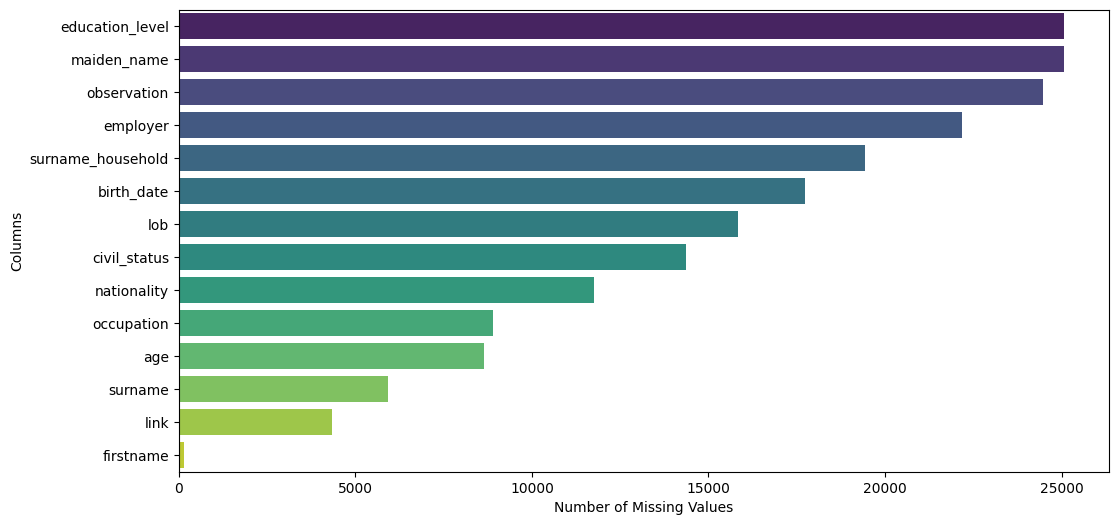

In [9]:
from src.descriptives import plot_missings
plot_missings(missings)

In [10]:
# verification de la nationalité
(
    data["nationality"].dropna().str.lower().value_counts(ascending=False)
    * 100
    / len(data["nationality"].dropna())
).head(10)

nationality
française     60.214811
idem          33.453508
français       2.831606
francaise      2.080517
polonaise      0.398077
id             0.172750
espagnole      0.112663
belge          0.105152
polonais       0.067598
portugaise     0.060087
Name: count, dtype: float64

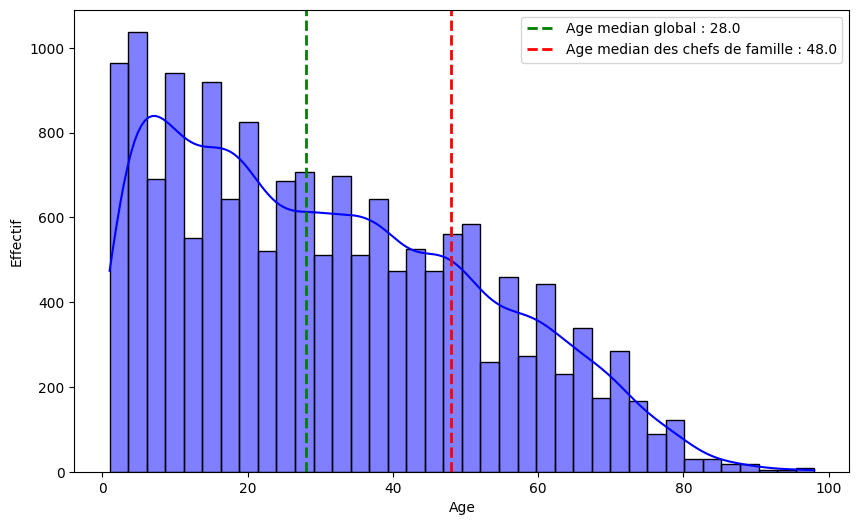

In [11]:
plot_ages(data)

In [12]:
# etude de la parité
round(data["civil_status"].dropna().value_counts() * 100 / len(data["civil_status"].dropna()), 2)

civil_status
Garçon    26.38
Fille     26.37
Homme     20.00
Femme     19.74
Veuve      4.78
Veuf       2.73
Name: count, dtype: float64

In [13]:
# etude du lien de parenté
data["link"].str.lower().str.strip().value_counts().head(10)

link
chef          4516
sa            2802
leur          2263
idem          2152
fils          1546
fille         1446
femme         1215
épouse         905
son            685
domestique     532
Name: count, dtype: int64

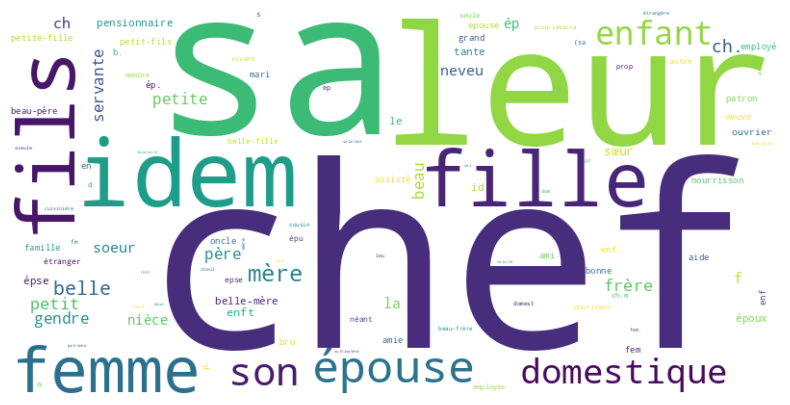

In [14]:
plot_wordcloud(data, "link")

In [15]:
chef_link = (data['link'].str.lower() == 'chef')
chef_token = (~data['surname_household'].isna())

print(data.shape)
print("# de 'chef' dans la colonne link effectivement chef de ménage:", len(data[chef_token & chef_link]))
print("# de 'chef' dans la colonne link non chef de ménage:", len(data[~chef_token & chef_link]))
print("# de non 'chef' dans la colonne link chef de ménage:", len(data[chef_token & ~chef_link]))
print("# de non 'chef' dans la colonne link non chef de ménage:", len(data[~chef_token & ~chef_link]))

(25075, 14)
# de 'chef' dans la colonne link effectivement chef de ménage: 3737
# de 'chef' dans la colonne link non chef de ménage: 779
# de non 'chef' dans la colonne link chef de ménage: 1903
# de non 'chef' dans la colonne link non chef de ménage: 18656


In [16]:
import re
import numpy as np

def filter_one_age(age):
    if isinstance(age, str):
        if re.match(r"^[0-9]+$", age):
            return int(age)
        else:
            return np.nan
    else:
        try:
            return int(age)
        except ValueError:
            return np.nan

print(len(data[chef_token & (data['age'].apply(filter_one_age) < 18)]))

12


In [17]:
X, y = get_features(data)
X, X.shape, y.shape

(array(['25 Garçon Cyrille française menuisier Breton',
        '30 Garçon Auguste Piémontaise vitrier',
        '24 Garçon Pierre Piémontaise vitrier', ...,
        '1886 Baretto Nello chef Castel italienne manoeuvre',
        '1887 Annunziata épouse idem idem Berni-Laureti',
        '1914 Primo fils idem idem Berni'], dtype='<U79'),
 (25075,),
 (25075,))

In [18]:
print(f"Nombre et proportion de chefs de ménages dans l'échantillon: {y.sum()} et {round((y.sum() / len(y)) * 100, 2)}%.")

Nombre et proportion de chefs de ménages dans l'échantillon: 5640 et 22.49%.


## 3) Experiments

In [19]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, params)

### Baseline

In [46]:
import src.baseline as baseline

param_grid = baseline.make_grid()
X_train_tfidf, X_test_tfidf = baseline.fit_transform_tdidf(X_train, X_test)
grid_search = baseline.perform_grid_search(X_train_tfidf, y_train, param_grid)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

accuracy, report = baseline.evaluate_model(grid_search.best_estimator_, X_test_tfidf, y_test)
print("Accuracy on Test Set:", accuracy)
print("Classification Report:\n", report)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-validation Score: 0.9437316783816697
Accuracy on Test Set: 0.9347956131605184
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      3887
           1       0.82      0.91      0.86      1128

    accuracy                           0.93      5015
   macro avg       0.90      0.93      0.91      5015
weighted avg       0.94      0.93      0.94      5015



### Example: CamemBERT finetuning

Nous allons montrer un exemple d'utilisation de notre code (dont l'implémentation complète est réalisée à partir du script `main.py`).
Nous réalisons ici le finetuning de CamemBERT base, avec implémentation d'une procédure d'early-stopping.

In [20]:
from conf.config import models

model_name = 'almanach/camembert-base'
tokenizer_class, model_class = models[model_name]
tokenizer = tokenizer_class.from_pretrained(model_name)

train_dataloader, val_dataloader, test_dataloader = [
    get_dataloader(
        features, labels, tokenizer, batch_size=params["batch_size"]
    ) for features, labels in zip([X_train, X_val, X_test], [y_train, y_val, y_test])
]

model = model_class.from_pretrained(
    model_name, num_labels=len(np.unique(y_train))
    )
model.to(device)
model_name = model_name.split('/')[-1]
run_finetuning(
    tokenizer, model, model_name, params,
    train_dataloader, val_dataloader, test_dataloader,
    es=True, device=device
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters to be learned: 110623490
======== Epoch 1 / 6 ========


  1%|          | 4/502 [00:07<14:54,  1.80s/it]


KeyboardInterrupt: 

On peut enfin afficher les métriques et quelques plots en allant chercher ces derniers à l'endroit où la fonction `run_finetuning`les a sauvegardé :

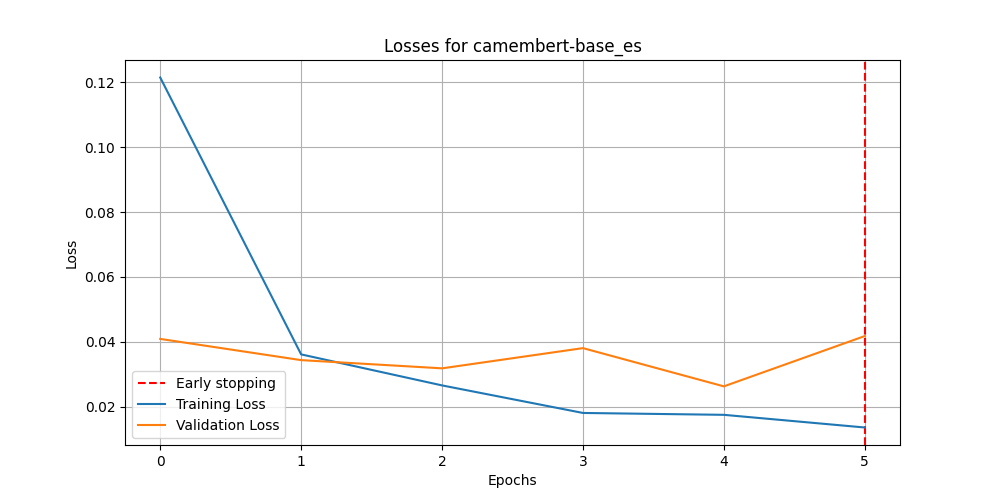

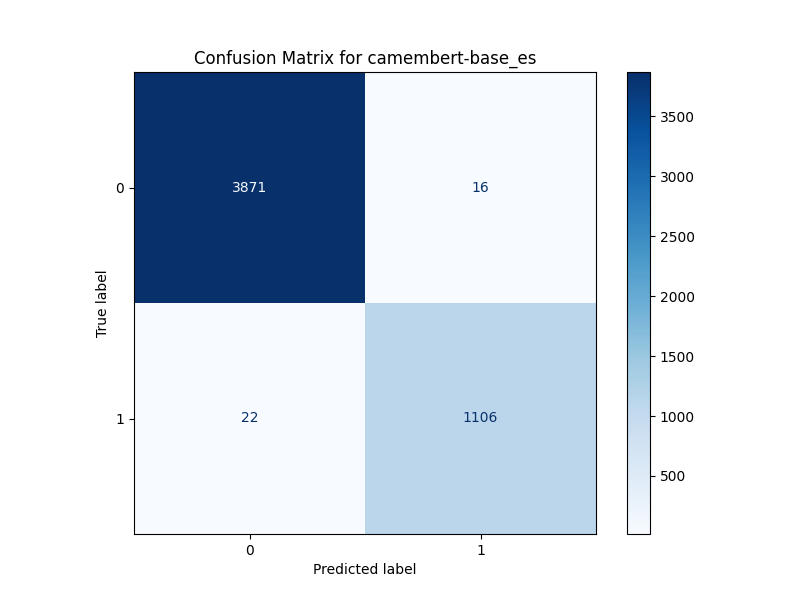

In [111]:
img = Image.open('assets/plots/losses/camembert-base_es.png')
img.show()

img = Image.open('assets/plots/confusion/camembert-base_es.png')
img.show()

In [10]:
classif_report = get_data("data/outputs/camembert-base_es/classif_report.json")
for label, metrics in classif_report.items():
    if isinstance(metrics, dict):
        print(f"Class {label}:")
        for metric_name, metric_value in metrics.items():
            print(f"  {metric_name.capitalize()}: {metric_value:.2f}")
    else:
        print(f"{label.capitalize()}: {metrics:.2f}")
    print()

Class 0:
  Precision: 0.99
  Recall: 1.00
  F1-score: 1.00
  Support: 3962.00

Class 1:
  Precision: 0.99
  Recall: 0.98
  F1-score: 0.98
  Support: 1128.00

Accuracy: 0.99

Class macro avg:
  Precision: 0.99
  Recall: 0.99
  F1-score: 0.99
  Support: 5090.00

Class weighted avg:
  Precision: 0.99
  Recall: 0.99
  F1-score: 0.99
  Support: 5090.00



## Exemple de code pour l'inférence

Nous montrons ici un exemple générique pour effectuer une tâche d'inférence à partir d'un de nos modèles finetunés. En l'occurence, nous faisons l'exemple pour `bert-base-cased`.

In [139]:
from conf.config import models
from src.inference import get_finetuned_model, predict_from_finetuned_model

finetuned_model, tokenizer = get_finetuned_model(
    'google-bert/bert-base-cased', models=models, device=device, es=True
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

In [149]:
indices = [0, -1]
examples = {X_val[i]: y_val[i] for i in indices}
for ex in examples.items():
    print(ex, "\n")

('34 Isidore chef française couvreur', 1) 

('1880 Anais femme St française néant Mouton', 0) 



In [161]:
predicted_classes, probabilities = predict_from_finetuned_model(
    finetuned_model, tokenizer, list(examples.keys())
)

for i, example in enumerate(examples.items()):
    ex, label = example
    print(ex)
    print("Ground truth label:", label)
    print("Predict label:", predicted_classes[i])
    print("Predicted probabilties:", probabilities[i].cpu().numpy())
    print("\n")

34 Isidore chef française couvreur
Ground truth label: 1
Predict label: 1
Predicted probabilties: [1.18423675e-04 9.99881506e-01]


1880 Anais femme St française néant Mouton
Ground truth label: 0
Predict label: 0
Predicted probabilties: [9.9994361e-01 5.6427612e-05]


